The training dataset consists of 1000 sunflower images.
Adopted the recommended learning rate (lr) of 0.0002 for using Wasserstein GAN

Training start!
Epoch [100/500], D Loss: -3.0729, G Loss: 1.4823


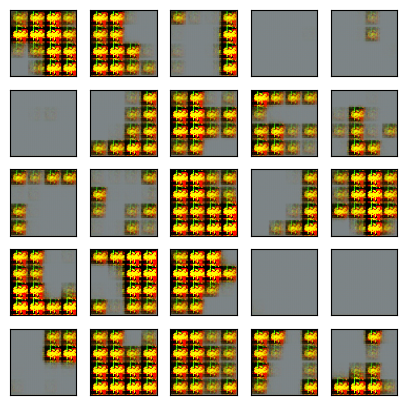

Epoch [200/500], D Loss: -2.9951, G Loss: 1.4667


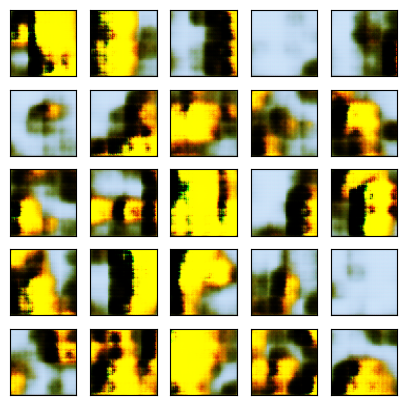

Epoch [300/500], D Loss: -2.7866, G Loss: 1.3593


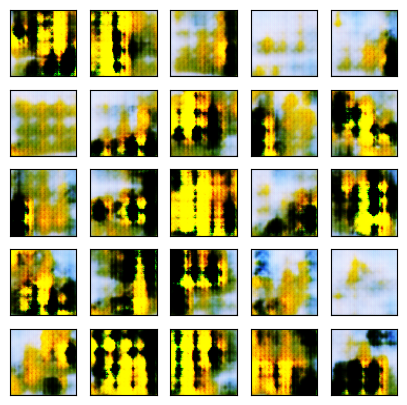

Epoch [400/500], D Loss: -2.7887, G Loss: 1.4532


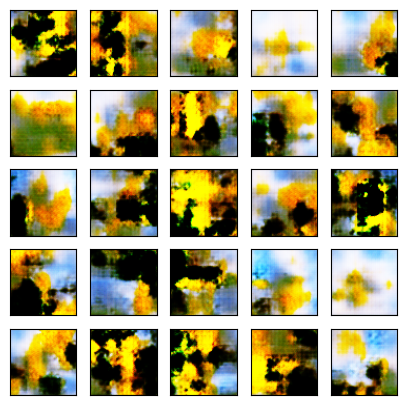

Epoch [500/500], D Loss: -2.7369, G Loss: 1.1426


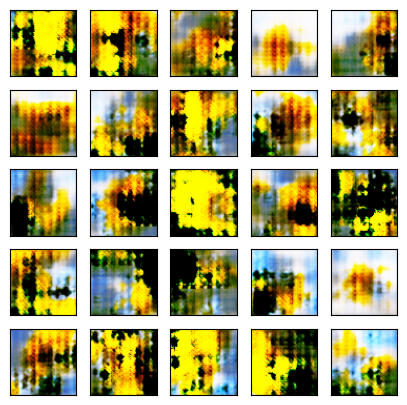

Total training time: 741.23s


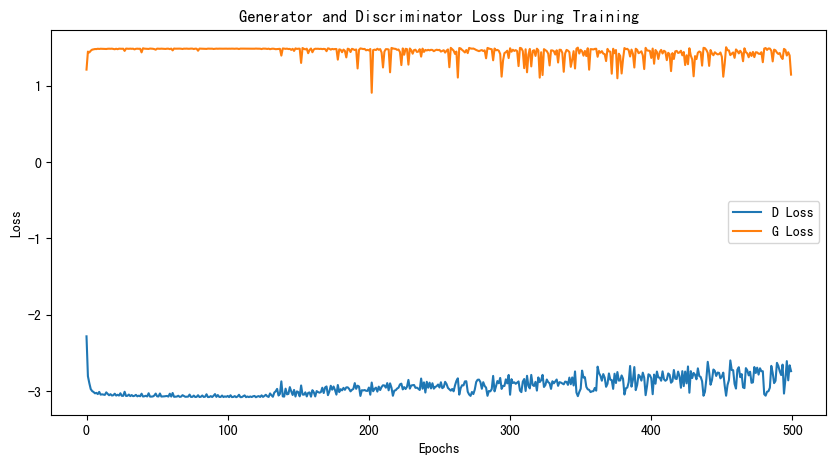

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import itertools 
import torch.nn.functional as F


class Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)  
        return x


batch_size = 32
lr = 0.0002  
train_epoch = 500
img_size = 64
clip_value = 0.01  
n_critic = 5 


transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'sunflower'
dataset = Dataset(root_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


G = Generator(128).cuda()
D = Discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G_optimizer = optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=lr)

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []


print('Training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for i, x_ in enumerate(train_loader):

        for _ in range(n_critic):
            D.zero_grad()
            x_ = x_.cuda()
            D_result_real = D(x_).squeeze()
            D_loss_real = -torch.mean(D_result_real)

            z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
            G_result = G(z_)
            D_result_fake = D(G_result).squeeze()
            D_loss_fake = torch.mean(D_result_fake)

            D_train_loss = D_loss_real + D_loss_fake
            D_train_loss.backward()
            D_optimizer.step()

            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

            D_epoch_losses.append(D_train_loss.item())

        if i % n_critic == 0:
            G.zero_grad()
            z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
            G_result = G(z_)
            D_result = D(G_result).squeeze()
            G_train_loss = -torch.mean(D_result)
            G_train_loss.backward()
            G_optimizer.step()
            G_epoch_losses.append(G_train_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2
            test_images = torch.clamp(test_images, 0, 1)
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Emm, the generated images are too abstract.
The loss function is converging too slowly.
I will try increasing the learning rate, changing it from 0.0002 to 0.001.

Training start!
Epoch [100/500], D Loss: -1.2877, G Loss: 0.6037


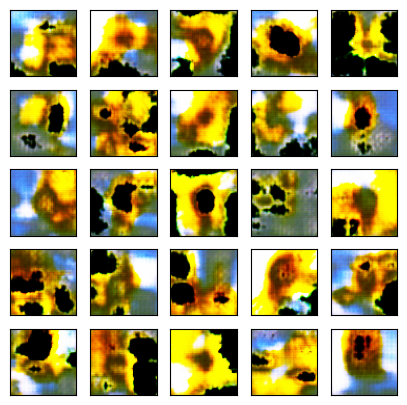

Epoch [200/500], D Loss: -1.1285, G Loss: 0.4798


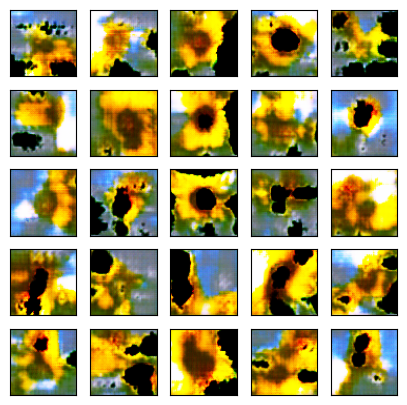

Epoch [300/500], D Loss: -1.0371, G Loss: 0.5462


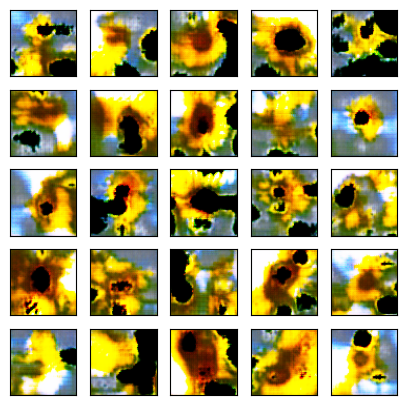

Epoch [400/500], D Loss: -0.8576, G Loss: 0.3941


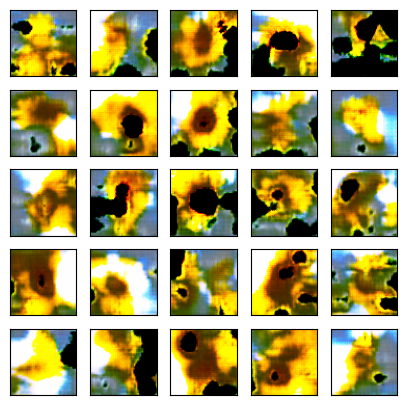

Epoch [500/500], D Loss: -0.8351, G Loss: 0.4854


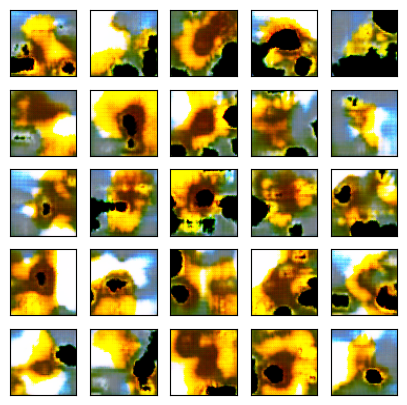

Total training time: 943.18s


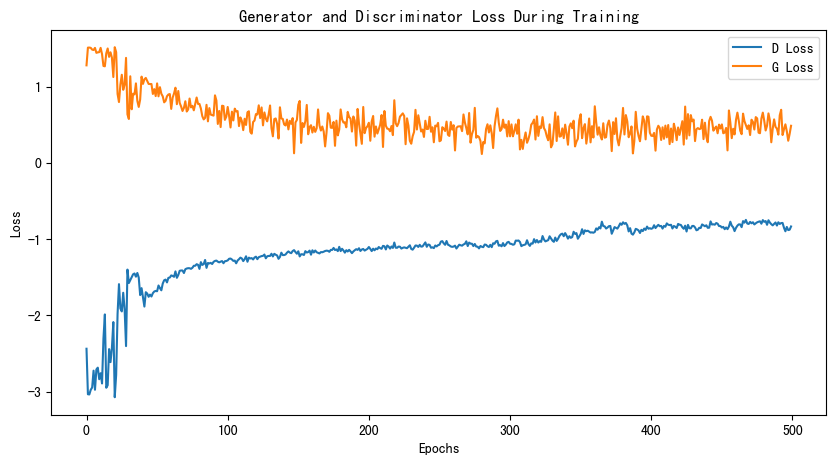

In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import itertools 
import torch.nn.functional as F


class Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)  
        return x


batch_size = 32
lr = 0.001
train_epoch = 500
img_size = 64
clip_value = 0.01 
n_critic = 5  


transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'sunflower'
dataset = Dataset(root_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


G = Generator(128).cuda()
D = Discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G_optimizer = optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=lr)

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []


print('Training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for i, x_ in enumerate(train_loader):

        for _ in range(n_critic):
            D.zero_grad()
            x_ = x_.cuda()
            D_result_real = D(x_).squeeze()
            D_loss_real = -torch.mean(D_result_real)

            z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
            G_result = G(z_)
            D_result_fake = D(G_result).squeeze()
            D_loss_fake = torch.mean(D_result_fake)

            D_train_loss = D_loss_real + D_loss_fake
            D_train_loss.backward()
            D_optimizer.step()

            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)
                
            D_epoch_losses.append(D_train_loss.item())

        if i % n_critic == 0:
            G.zero_grad()
            z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
            G_result = G(z_)
            D_result = D(G_result).squeeze()
            G_train_loss = -torch.mean(D_result)
            G_train_loss.backward()
            G_optimizer.step()
            G_epoch_losses.append(G_train_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2
            test_images = torch.clamp(test_images, 0, 1)
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

After increasing the learning rate to 0.001, the generated images look much better than in the previous round, 
but it seems that the loss function does not decrease significantly after 200 epochs.
It appears that using a fixed learning rate is not a very good strategy. 
Next, I will try using a learning rate scheduling strategy, StepLR, 
where the learning rate will be reduced to 80% of its current value every 250 epochs.

Training start!
Epoch [100/500], D Loss: -1.3446, G Loss: 0.6614


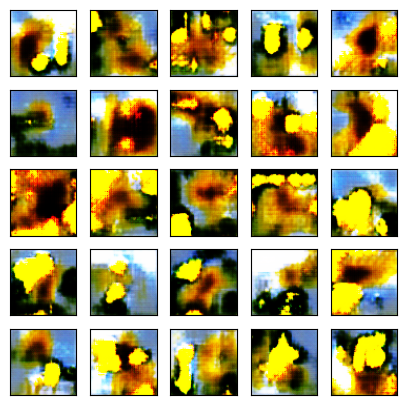

Epoch [200/500], D Loss: -1.1567, G Loss: 0.4358


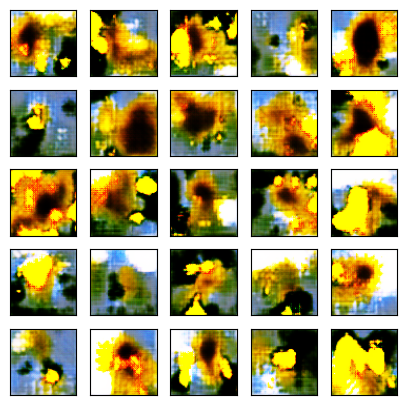

Epoch [300/500], D Loss: -1.4190, G Loss: 0.6451


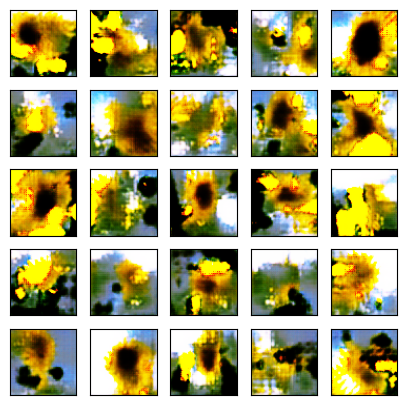

Epoch [400/500], D Loss: -1.2303, G Loss: 0.3878


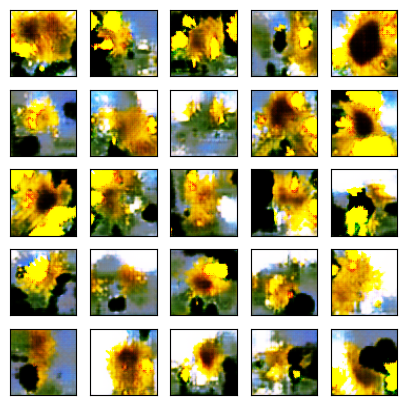

Epoch [500/500], D Loss: -1.2183, G Loss: 0.4277


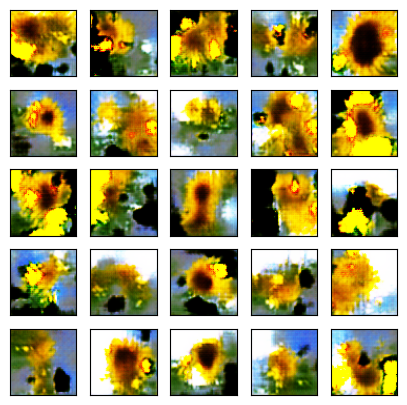

Total training time: 724.37s


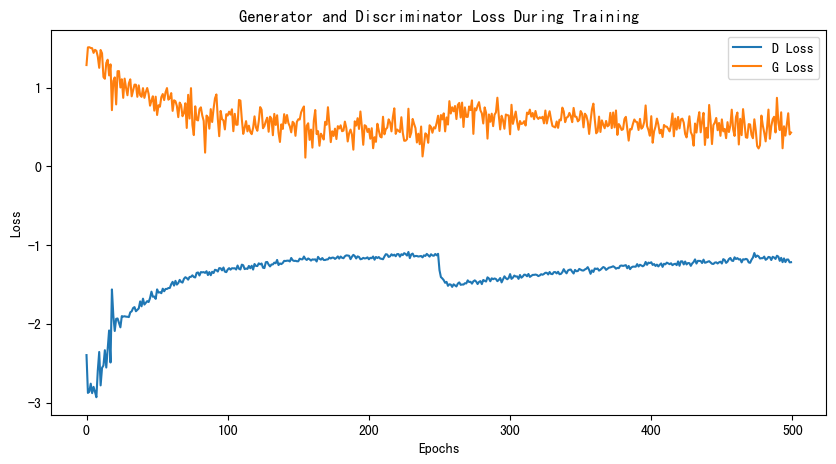

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import itertools  
import torch.nn.functional as F


class Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)  
        return x


batch_size = 32
initial_lr = 0.001 
train_epoch = 500
img_size = 64
clip_value = 0.01  
n_critic = 5  


transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'sunflower'
dataset = Dataset(root_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


G = Generator(128).cuda()
D = Discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G_optimizer = optim.RMSprop(G.parameters(), lr=initial_lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=initial_lr)
scheduler_G = lr_scheduler.ExponentialLR(optimizer=G_optimizer, gamma=0.8)
scheduler_D = lr_scheduler.ExponentialLR(optimizer=D_optimizer, gamma=0.8)

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []


print('Training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for i, x_ in enumerate(train_loader):

        for _ in range(n_critic):
            D.zero_grad()
            x_ = x_.cuda()
            D_result_real = D(x_).squeeze()
            D_loss_real = -torch.mean(D_result_real)

            z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
            G_result = G(z_)
            D_result_fake = D(G_result).squeeze()
            D_loss_fake = torch.mean(D_result_fake)

            D_train_loss = D_loss_real + D_loss_fake
            D_train_loss.backward()
            D_optimizer.step()

            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

            D_epoch_losses.append(D_train_loss.item())

        if i % n_critic == 0:
            G.zero_grad()
            z_ = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
            G_result = G(z_)
            D_result = D(G_result).squeeze()
            G_train_loss = -torch.mean(D_result)
            G_train_loss.backward()
            G_optimizer.step()
            G_epoch_losses.append(G_train_loss.item())

    if (epoch + 1) % 250 == 0:  
        scheduler_G.step()
        scheduler_D.step()

    if (epoch + 1) % 100 == 0:  
        print(
            f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2
            test_images = torch.clamp(test_images, 0, 1)
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Uh, it seems that using StepLR has resulted in worse performance compared to a fixed learning rate.
Additionally, there are still small black patches in the images, 
similar to the black patches in the generated cloud images, 
indicating that the issue is not with the dataset.
Could this be related to the GAN model? 
Next, I will try using some different GAN models.